<a href="https://colab.research.google.com/github/ravibishnoiii/machine-learning-project/blob/main/End_to_End_Housing_Price_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***End-to-End California Housing Price Prediction Project***

In [ ]:
print("Welcome to the ML Project !")

Welcome to the ML Project !


To Check Python is 3.7 or above

In [ ]:
import sys

assert sys.version_info >= (3,7)


To check scikit learn is >= 1.0.1 :

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

## *Fetching and Loading the Data*

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
      Path("datasets").mkdir(parents=True,exist_ok=True)
      url = "https://github.com/ageron/data/raw/main/housing.tgz"
      urllib.request.urlretrieve(url,tarball_path)
      with tarfile.open(tarball_path) as housing_tarball:
          housing_tarball.extractall(path="datasets")
      return pd.read_csv(Path("datasets/housing/housing.csv"))
housing = load_housing_data()

In [ ]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


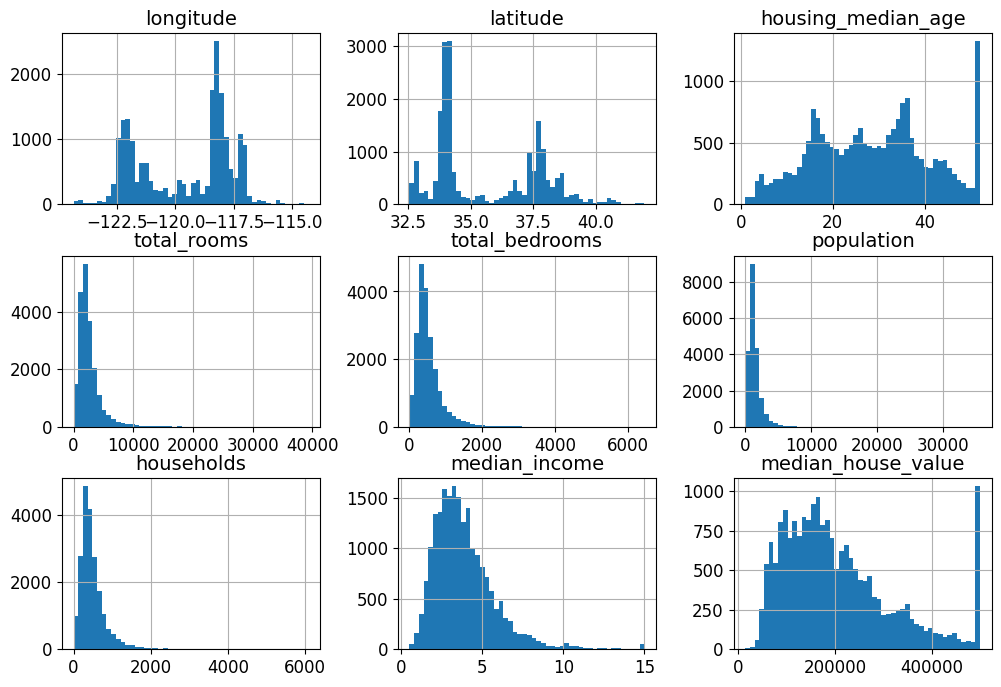

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14 , titlesize=14)
plt.rc('legend' , fontsize=14)
plt.rc('xtick' , labelsize=12)
plt.rc('ytick' , labelsize=12)

housing.hist(bins=50, figsize=(12,8))
plt.show()

## Creating a Test Set

In [ ]:
import numpy as np

def shuffle_and_split_data(data,test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data)*test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]


In [ ]:
train_set , test_set = shuffle_and_split_data(housing,0.2)
len(train_set)

16512

In [ ]:
len(test_set)

4128

In [ ]:
np.random.seed(42)

In [ ]:
from zlib import crc32

def is_id_in_test_set(identifier,test_ratio):
    return crc32(np.int64(identifier))<test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_,test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
housing_with_id = housing.reset_index()
train_set , test_set = split_data_with_id_hash(housing_with_id,0.2,"index")

In [ ]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set , test_set = split_data_with_id_hash(housing_with_id,0.2, "id")


In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
test_set["total_bedrooms"].isnull().sum()

44

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],bins=[0., 1.5, 3.0, 4.5, 6., np.inf],labels=[1,2,3,4,5])

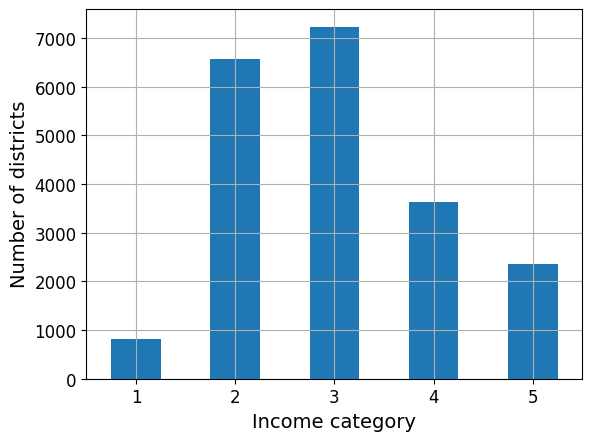

In [ ]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0,grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n ])

In [ ]:
strat_train_set, strat_test_set = strat_splits[0]

In [ ]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [ ]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Visualizing the Data to Gain Insights

In [ ]:
housing = strat_train_set.copy()

## Visualizing Geographical Data

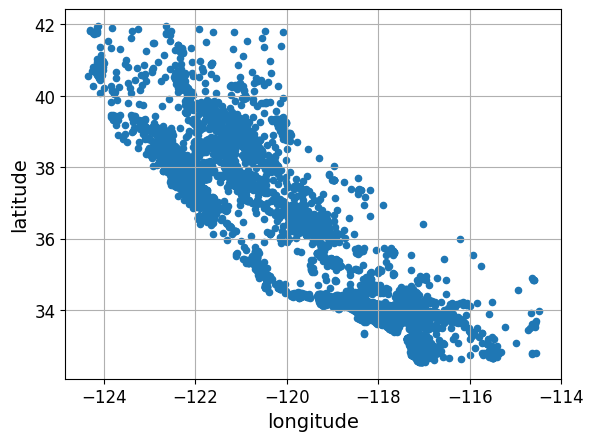

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

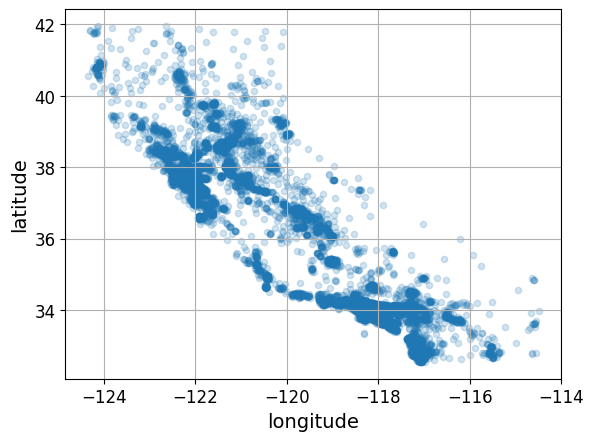

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

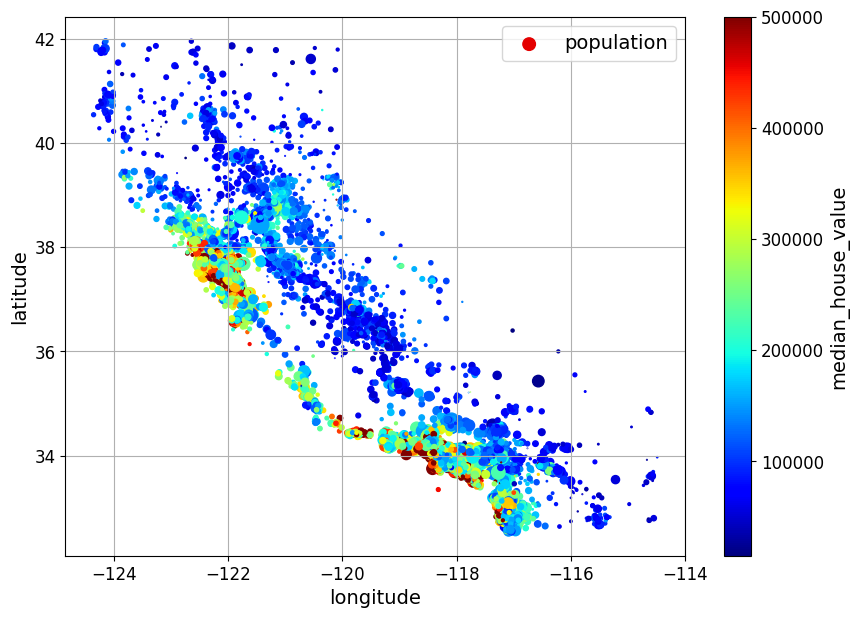

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"] / 100, label="population", c="median_house_value", cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10,7))
plt.show()

## Looking for correlations:

We need to look at correlations in the dataset to understand the relationships between different attributes.
Correlation helps identify which attributes are most strongly related to the target variable (in this case, median_house_value).
we can understand how different attributes interact with each other. For example, if median_income has a strong positive correlation with median_house_value, it indicates that higher income levels are associated with higher house values.

In [ ]:
corr_matrix = housing.corr(numeric_only=True)

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
longitude,-0.050859
latitude,-0.139584


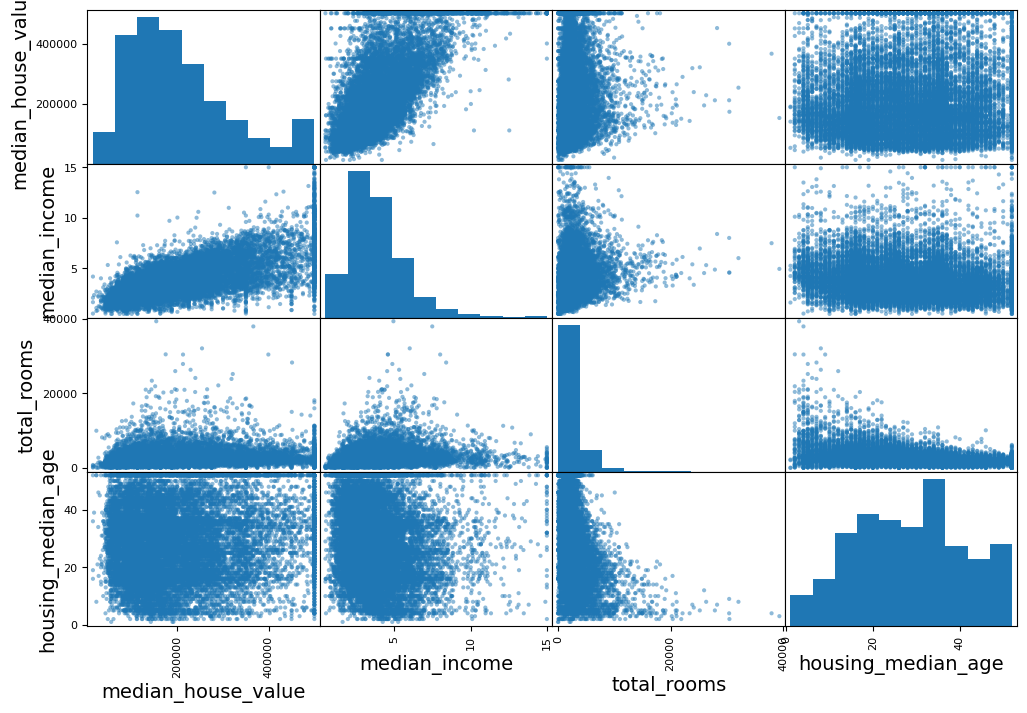

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

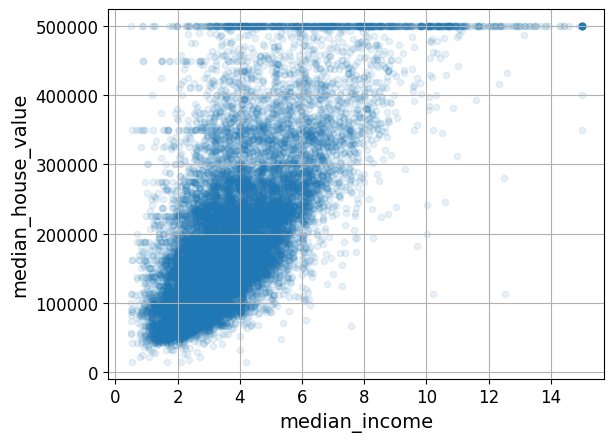

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
plt.show()

<ipython-input-1-3359f2acf728>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tech_roles, y=job_postings, palette="viridis")


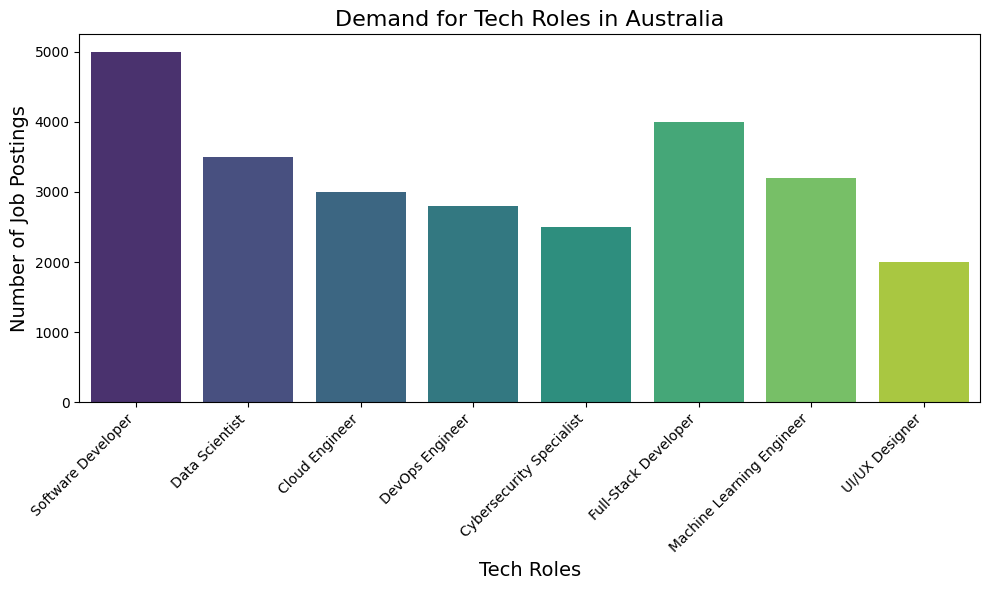